Team - Aidan Cusa, Andrew Yuan, Kristof Jablonowski

In [201]:
import numpy as np
from scipy.stats import multivariate_normal

# Kept having a bunch of dividing by zero and infinity values so we added in a small epsilon when needed to avoid these errors.

# pdf used to evaluate at x_n
def gaussian_pdf_1d(x, mu, var):
    return (1.0 / np.sqrt(2 * np.pi * var)) * np.exp(-(x - mu) ** 2 / (2 * var))

# equation 9.23 in the book
def calculate_responsibilites(data, pi, mu, sigma, epsilon=1e-6):
    dims = np.array(data).ndim
    if dims == 1: data = data[:, None]
    N, D = data.shape

    responsibilities = np.zeros((N, len(pi)))
    for n in range(N):
        for k in range(len(pi)): # len(pi) = K
            if D == 1: responsibilities[n, k] = pi[k] * gaussian_pdf_1d(data[n, 0], mu[k], sigma[k])
            if D == 2: responsibilities[n, k] = pi[k] * multivariate_normal.pdf(data[n, :], mean=mu[k], cov=sigma[k], allow_singular=True)

    return responsibilities / (np.sum(responsibilities, axis=1, keepdims=True) + epsilon)


# equation 9.28 in the book
def log_likelihood(data, pi, mu, sigma, epsilon=1e-6):
    dims = np.array(data).ndim
    if dims == 1: data = data[:, None]
    N, D = data.shape

    total_sum = 0
    for n in range(N):
        inner_sum = 0
        for k in range(len(pi)): # len(pi) = K
            if D == 1: inner_sum += pi[k] * gaussian_pdf_1d(data[n], mu[k], sigma[k])
            if D == 2: inner_sum += pi[k] * multivariate_normal.pdf(data[n, :], mean=mu[k], cov=sigma[k], allow_singular=True)
        total_sum += np.log(inner_sum + epsilon)

    return total_sum

In [202]:
def run_em(data, K, max_iters, threshold=0.2, epsilon=1e-6):
    dims = np.array(data).ndim
    if dims == 1: data = data[:, None]
    N, D = data.shape

    pi = np.ones(K) / K # uniform distribution initilization

    # initialize values for mu and sigma - this was cruicial
    if D == 1:
        mu = np.random.uniform(data.min(), data.max(), size=K) # randomly initialize means within data range
        sigma = np.full(K, data.var()) # initialize all vars to total data variance
    else:
        mu = data[np.random.choice(N, size=K, replace=False), :]
        base_cov = np.cov(data.T) + epsilon*np.eye(D)
        sigma = np.stack([base_cov.copy() for _ in range(K)], axis=0) # (K, D, D) matrix

    # calculate responsibilities and log likelihoods
    responsibilities = calculate_responsibilites(data, pi, mu, sigma)
    ll_old = log_likelihood(data, pi, mu, sigma)

    # save copies of results in as tuples in a list
    results = [(pi.copy(), mu.copy(), sigma.copy())]

    for i in range(1, max_iters):
        gamma = calculate_responsibilites(data, pi, mu, sigma)

        N_k = np.sum(gamma, axis=0)

        # calculate new values for pi, mu, and sigma
        pi = N_k / N

        # 1D case
        if dims == 1:
            # means
            mu = (gamma.T @ data[:, 0]) / (N_k + epsilon)

            # covariances
            sigma_new = np.zeros(sigma.shape)
            for k in range(K):
                sigma_total = 0.0
                for n in range(N):
                    sigma_total += gamma[n, k] * (data[n, 0] - mu[k]) * (data[n, 0] - mu[k]).T
                sigma[k] = sigma_total / (N_k[k] + epsilon)

        # 2D case
        else:
            # means (2D)
            for k in range(K):
                num = np.zeros(D)
                for n in range(N):
                    num += gamma[n, k] * data[n, :]
                mu[k, :] = num / (N_k[k] + epsilon)

            # covariances (2D)
            for k in range(K):
                Sk = np.zeros((D, D))
                for n in range(N):
                    d = (data[n, :] - mu[k, :]).reshape(D, 1)
                    Sk += gamma[n, k] * (d @ d.T)
                sigma[k, :, :] = Sk / (N_k[k] + epsilon)

        # recalculate log likelihood
        ll = log_likelihood(data, pi, mu, sigma)

        # save results
        results.append((pi.copy(), mu.copy(), sigma.copy()))

        # threshold test using L1
        if np.abs(ll - ll_old) < threshold:
            print(f"converged at {i}th iteration")
            break

        ll_old = ll

    return results


converged at 45th iteration


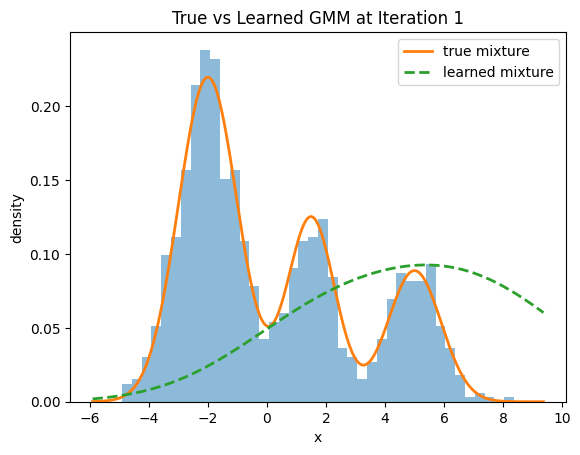

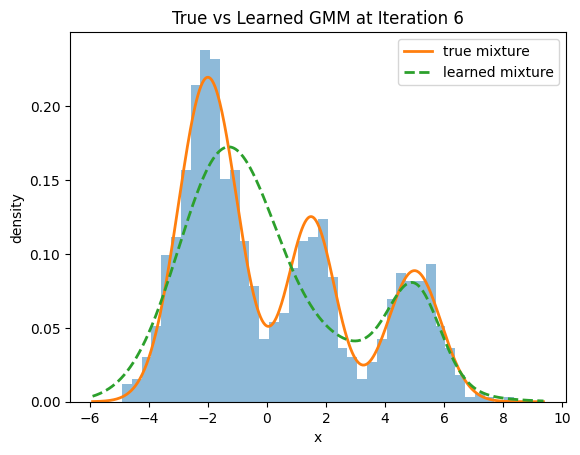

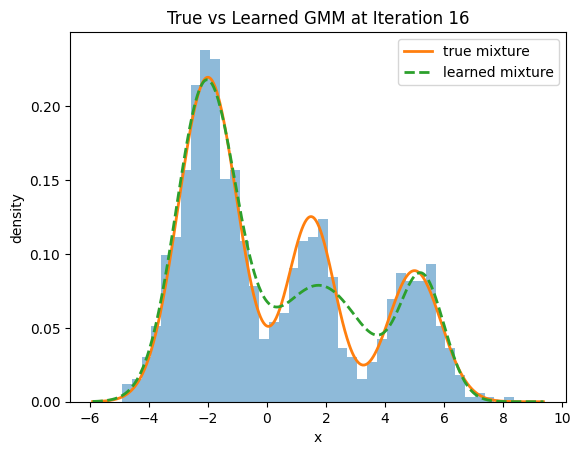

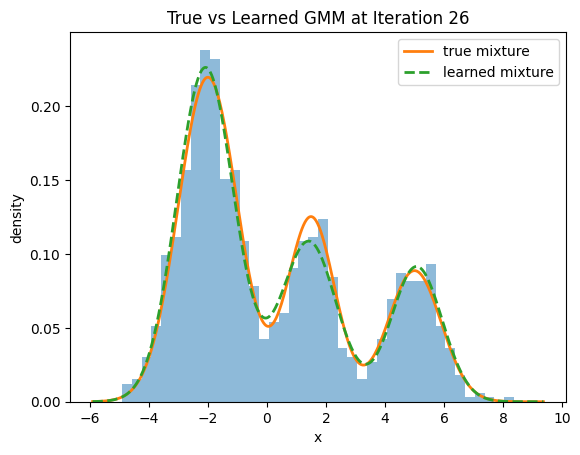

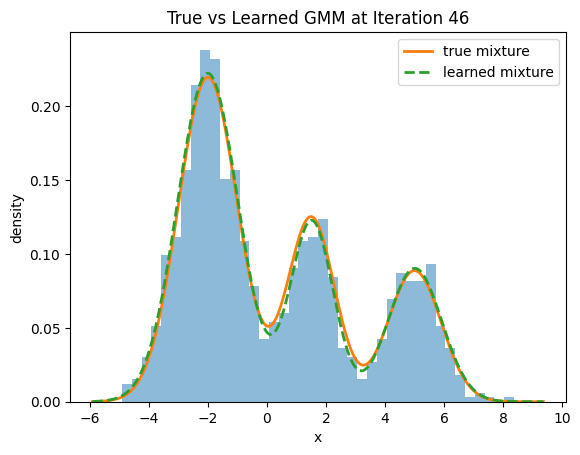

In [203]:
import numpy as np
import matplotlib.pyplot as plt

K = 3 # num gaussians in the mixture
N = 1000 # number of samples

np.random.seed(7)

true_pi = np.array([0.55, 0.25, 0.20]) # must sum to 1
true_mu = np.array([-2.0, 1.5, 5.0])
true_sigma = np.array([1**2, 0.8**2, 0.9**2])

# N random choices for z using true probs
z = np.random.choice(K, size=N, p=true_pi)

# randomly generate data
data = np.array([np.random.normal(true_mu[k], np.sqrt(true_sigma[k])) for k in z])

# run em algorithm, set threshold here
results = run_em(data=data, K=K, max_iters=1000, threshold=0.001)

# plot a couple indices
indices_to_plot = [0, 5, 15, 25, -1]
for idx in indices_to_plot:
    pi, mu, sigma = results[idx]
    x = np.linspace(data.min()-1, data.max()+1, 600)

    true_mix = np.zeros_like(x)
    for k in range(K):
        true_mix += true_pi[k] * gaussian_pdf_1d(x, true_mu[k], true_sigma[k])

    learned_mix = np.zeros_like(x)
    for k in range(len(pi)):
        learned_mix += pi[k] * gaussian_pdf_1d(x, mu[k], sigma[k])

    plt.hist(data, bins=40, density=True, alpha=0.5)
    plt.plot(x, true_mix, label="true mixture", lw=2)
    plt.plot(x, learned_mix, label="learned mixture", lw=2, linestyle="--")
    plt.legend()
    plt.xlabel("x"); plt.ylabel("density")
    plt.title(f"True vs Learned GMM at Iteration {idx + 1 if idx + 1 > 0 else len(results)}")
    plt.show()

2D Case

In [204]:
import kagglehub
import pandas as pd

# download old faithful dataset
path = kagglehub.dataset_download("janithwanni/old-faithful")
print("Path to dataset files:", path)

faithful_df = pd.read_csv("/kaggle/input/old-faithful/faithful.csv")
faithful_df

Using Colab cache for faster access to the 'old-faithful' dataset.
Path to dataset files: /kaggle/input/old-faithful


,Unnamed: 0,eruptions,waiting
0,1,3.600,79
1,2,1.800,54
2,3,3.333,74
3,4,2.283,62
4,5,4.533,85
...,...,...,...
267,268,4.117,81
268,269,2.150,46
269,270,4.417,90
270,271,1.817,46


In [205]:
K = 2 # num gaussians in the mixture
N = 1000 # number of samples

data = faithful_df[["eruptions", "waiting"]].to_numpy(dtype=float)

# run expectation maximization
results = run_em(data=data, K=K, max_iters=1000, threshold=0.0001)

# final parameters
pi, mu, Sigma = results[-1]
print("pi:\n", pi)
print("mu:\n", mu) # shape (K,2)
print("Sigma:\n", Sigma) # shape (K,2,2)

converged at 21th iteration
pi:
 [0.64404055 0.35579048]
mu:
 [[ 4.28971462 79.96847076]
 [ 2.0362667  54.4776519 ]]
Sigma:
 [[[ 0.16990862  0.93998677]
  [ 0.93998677 36.03559284]]

 [[ 0.06907933  0.4347516 ]
  [ 0.4347516  33.69242777]]]


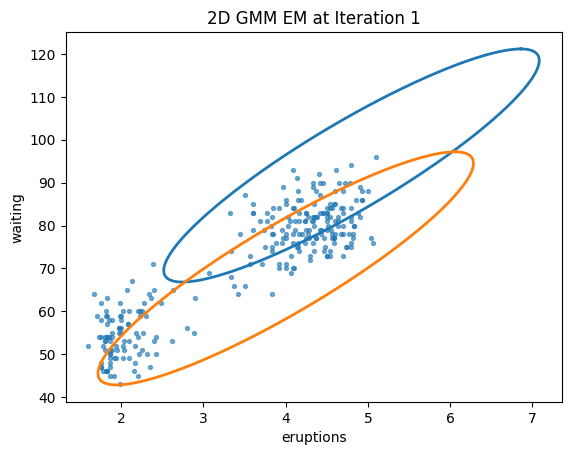

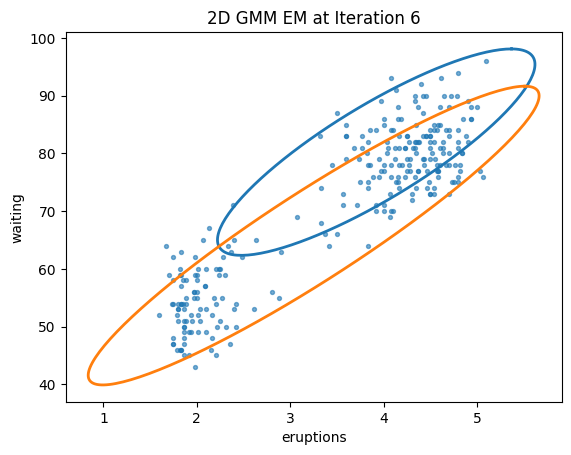

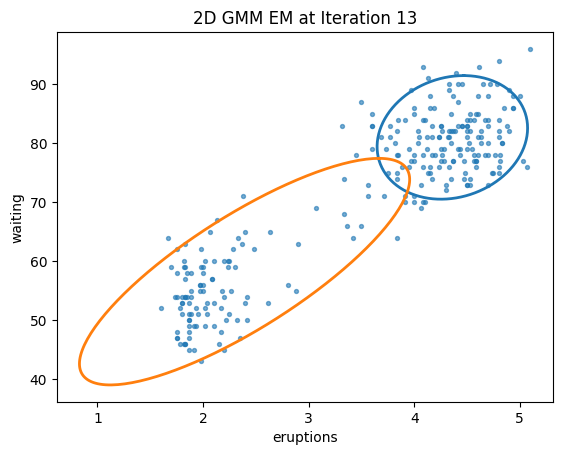

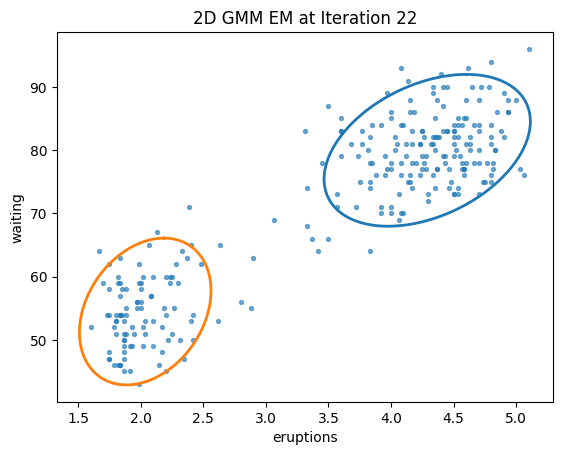

In [210]:
import numpy as np, matplotlib.pyplot as plt

# choose indices to plot
indices_to_plot = [0, 5, 12, -1]
for idx in indices_to_plot:
    pi, mu, Sigma = results[idx]

    # plot data points
    plt.scatter(data[:,0], data[:,1], s=8, alpha=0.6)

    # plot ellipses
    for k in range(len(pi)):
        vals, vecs = np.linalg.eigh(Sigma[k] + 1e-9*np.eye(2))
        order = vals.argsort()[::-1]; vals, vecs = vals[order], vecs[:,order]
        ang = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))

        # 2 * sigma widths for simplicity
        w, h = 2*2*np.sqrt(np.maximum(vals, 1e-12))
        t = np.linspace(0, 2*np.pi, 200)
        ex, ey = (w/2)*np.cos(t), (h/2)*np.sin(t)
        R = np.array([[np.cos(np.radians(ang)),-np.sin(np.radians(ang))],
                    [np.sin(np.radians(ang)), np.cos(np.radians(ang))]])
        E = (R @ np.vstack([ex,ey])) + mu[k].reshape(2,1)
        plt.plot(E[0], E[1], lw=2)

    plt.xlabel("eruptions"); plt.ylabel("waiting")
    plt.title(f"2D GMM EM at Iteration {idx + 1 if idx + 1 > 0 else len(results)}")
    plt.show()